# Classification with Dirichlet prior

In [1]:
%load_ext autoreload
%autoreload 2
import site
import time
site.addsitedir('..')

import jax
from jax.config import config
import jax.numpy as jnp
import numpy as np
from  matplotlib import pyplot as plt
from tqdm import tqdm

from jax.scipy.special import gammaln
from jax import random

from src.algorithm import *

plt.rcParams["figure.figsize"]=6,6
#config.update("jax_enable_x64", True)

### Setup

The probability vector $\pi$ is drawn from a Dirichlet distribution with parameter $\alpha$.

$\pi \sim \text{Dirichlet}(\alpha)$

The $K$ classes $x_1, \ldots, x_K$ are i.i.d. samples from a standard normal distribution and we have $N$ noisy observations $y_1, \ldots, y_N$ of the $K$ classes such that:

$y_i = x_{z_i} + \sigma \eta_i,$

where $\eta_i \sim \mathcal{N}(0,1)$ and $z_1, \ldots, z_N$ are drawn from a multinomial distribution with
probability vector $\pi$.

In [6]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
key, *subkeys = random.split(key, 5)

In [7]:
K = 10
N = 1000
sigma = 0.01
alpha = 0.7 * jnp.ones(K,)
#alpha = jnp.array([10,10,2])

In [8]:
pi = random.dirichlet(subkeys[0], alpha)
z = random.categorical(subkeys[1], jnp.log(pi), shape = (N,))
print(f"pi = {pi}")

pi = [0.14755723 0.23883411 0.00259012 0.03930138 0.15887733 0.11050232
 0.01476201 0.14792879 0.12903827 0.01060837]


x = [-0.42248565  0.47037852 -0.27125207  0.5280313  -2.1492865   2.2546678
  0.49364355  1.0142431  -1.0508072  -1.6258022 ]


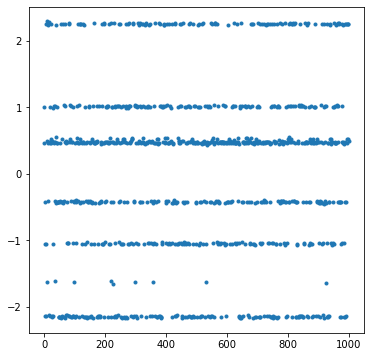

In [9]:
x = random.normal(subkeys[2], shape = (K,))
y = x[z] + sigma * random.normal(subkeys[3], shape = (N,))

print(f"x = {x}")
_ = plt.plot(y, '.')

### The posterior and proposal functions

In [10]:
# This log posterior marginalizes over the classes k = 1,...,K.
def logPi_marg(x, z, y, sigma, alpha):
    n_ik = calc_nik_jit(z)
    n_k = calc_nk_jit(z)
    
    log_arg = jnp.zeros(y.shape)

    Nk = jnp.sum(n_k)
    Ak = jnp.sum(alpha)
    
    term_mat = []
    for k in jnp.arange(K):
        logarg_k = jnp.exp(-(y - x[k])**2/sigma) *  (n_ik[:, k] + alpha[k])/(Nk+Ak-1)
        log_arg += logarg_k
        term_mat.append(logarg_k)
              
    return jnp.sum(jnp.log(log_arg)) - jnp.sum(x**2) 
   
# And this does not.
def logPi(x, z, y, sigma, alpha):
    n_k = calc_nk_jit(z)
    
    term1 = jnp.sum(-(y - x[z])**2/sigma)

    logPZalpha =  jnp.sum(gammaln(n_k + alpha))

    return term1 - jnp.sum(x**2) + logPZalpha 


def calc_nik_ki(z,k,i): 
    z = z.at[i].set(jnp.inf)    
    return jnp.sum(z == k)

calc_nik_i = lambda z, i : jax.vmap(calc_nik_ki, in_axes = (None, 0, None))(z, jnp.arange(K), i)
calc_nik = lambda z : jax.vmap(calc_nik_i, in_axes = (None, 0))(z, jnp.arange(N))
calc_nik_jit = jax.jit(calc_nik)

calc_nk_k = lambda z, k : jnp.sum(z == k)
calc_nk = lambda z : jax.vmap(calc_nk_k, in_axes = (None, 0))(z, jnp.arange(K))
calc_nk_jit = jax.jit(calc_nk)

In [75]:
print(logPi_marg(x, z, y, sigma, alpha))
print(logPi_marg(xi, zi, y, sigma, alpha))

-1811.4465
-2001.7443


In [76]:
print(logPi(x, z, y, sigma, alpha))
print(logPi(xi, zi, y, sigma, alpha))

3952.9385
3925.5513


In [12]:
@jax.jit
def proposal_x_marg(key, x0, logPiX0, B, z, y, sigma, alpha):
    """Proposal function of a new vector [x_1,...,x_k] from the posterior
    
    p(x_1, ..., x_K | y_1, ..., y_N)
    
    with marginalization over z_1,...z_N."""
    
    x1 = random.uniform(key, x0.shape) * 2*B-B
    
    logPiX0 = logPi_marg(x0, z, y, sigma, alpha)
    logPiX1 = logPi_marg(x1, z, y, sigma, alpha)
    
    r = jnp.exp((logPiX1 - logPiX0))
    
    return x1, r, logPiX1, logPiX0

@jax.jit
def proposal_x(key, x0, logPiX0, B, z, y, sigma, alpha):
    """Proposal function of a new vector [x_1,...,x_K] from the posterior
    
    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)

    without marginalization over z_i variales (where we keep z_i fixed)."""
    
    x1 = random.uniform(key, x0.shape) * 2*B-B
    
    logPiX0 = logPi(x0, z, y, sigma, alpha)
    logPiX1 = logPi(x1, z, y, sigma, alpha)
    
    r = jnp.exp((logPiX1 - logPiX0))
    
    return x1, r, logPiX1, logPiX0

@jax.jit
def proposal_x_idx(key, x0, logPiX0, B, z, y, sigma, alpha, idx):
    """Proposal function for a new state x_{idx} from the posterior
    
    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)
    
    where all z_i and the other x_j are fixed and with no
    marginalization over z.

    The returned vector x1 is equal to x0, 
    with the entry at index idx given by the proposal."""
    
    newval = random.uniform(key) * 2*B-B
    x1 = x0.at[idx].set(newval)
    
    logPiX0 = logPi(x0, z, y, sigma, alpha)
    logPiX1 = logPi(x1, z, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return x1, r, logPiX1, logPiX0    
               
@jax.jit
def proposal_x_batch(key, x0, logPiX0, B, z, y, sigma, alpha):
    """Proposal function for a new state x_j for all j = 1,..., K 
    from the posterior
    
    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)
    
    where all z_i and the other x_i (i !=j) are fixed and with no
    marginalization over z.
    
    This function returns a new proposal for each x_j i.e.
    it samples x_j "one variable at a time", but for all j 
    in parallel. 

    The returned vector x1 is the same dimensions as x0 and contains
    the proposal states corresponding to each entry. Similarly,
    r, logPiX1 and logPiX0 are arrays of length K, each entry corresponding
    to the proposal x_j with the other x_i fixed, so that this proposal function
    can be used in the "batch" mode of the mcmc function."""
        
    keys = random.split(key, K)
    
    x1, r, logPiX1, logPiX0 = jax.vmap(proposal_x_idx, in_axes = (0, None, None, None, None, None, None, None, 0))(keys, x0, logPiX0, B, z, y, sigma, alpha, jnp.arange(K))
    x1 = jnp.diag(x1)
    
    return x1, r, logPiX1, logPiX0

@jax.jit
def proposal_z(key, z0, logPiX0, x, y, sigma, alpha, K):
    """Proposal function of a new vector [z_1,...,z_N] from the posterior
    
    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)

    where the x_i variables are fixed."""
    
    z1 = random.randint(key, z0.shape, 0, K) 

    logPiX0 = logPi(x, z0, y, sigma, alpha)
    logPiX1 = logPi(x, z1, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return z1, r, logPiX1, logPiX0

@jax.jit
def proposal_z_idx(key, z0, logPiX0, x, y, sigma, alpha, K, idx):
    """Proposal function of a new state z_{idx} from the posterior
    
    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)

    where all x_i and the other z_j are fixed.
    
    The returned vector z1 is equal to z0, 
    with the entry at index idx given by the proposal."""
    
    newval = random.randint(key, (), 0, K) 
    z1 = z0.at[idx].set(newval)
    
    logPiX0 = logPi(x, z0, y, sigma, alpha)
    logPiX1 = logPi(x, z1, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return z1, r, logPiX1, logPiX0

@jax.jit
def proposal_z_batch(key, z0, logPiX0, x, y, sigma, alpha, K):
    """Batch mode proposal function for z, operating in the same
    way as proposal_x_batch. 
    
    If the posterior depends on the states z_1,...,z_N (e.g. due to 
    the Dirichlet prior), then running MCMC with this proposal function
    is NOT correct. However, this function is used in the
    proposal_z_batch_correct" function, which takes advantage of these
    parallel proposals in a proper MCMC way."""
    
    keys = random.split(key, N)
    
    # TODO: change both batch functions so we don't have to do diag on an N x N (or K x K) matrix
    z1, r, logPiX1, logPiX0 = jax.vmap(proposal_z_idx, in_axes = (0, None, None, None, None, None, None, None, 0))(keys, z0, logPiX0, x, y, sigma, alpha, K, jnp.arange(N))
    z1 = jnp.diag(z1)
    
    return z1, r, logPiX1, logPiX0
    
@jax.jit
def proposal_z_batch_correct(key, z0, logPiX0, x, y, sigma, alpha, K):
    """If using the Dirichlet posterior, then the proposal_z_batch is not 
    proper MCMC sampling. Here, we run a number of "incorect" MCMC steps to 
    sample all the entries of z in parallel, and then use the latest 
    proposed z as a proposal for a "correct" MCMC proposal. The acceptance rate
    is pretty good in this toy example and the convergence great."""
    
    N_samples_z_local = 10   
    keys = random.split(key, 2*N_samples_z_local)
    params_z = {"x" : x, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K}
    
    logPiZ0 = logPi(x, z0, y, sigma, alpha)
    
    for i in jnp.arange(N_samples_z_local):
        z1, r, logPiX1, logPiX0 = proposal_z_batch(keys[2*i], z0, logPiZ0, **params_z)
        a = jnp.minimum(1, r)
        unif_var = random.uniform(keys[2*i+1], (N,))
        z1, logPiX1 = accept_reject_vmap(unif_var, a, z0, z1, logPiX0, logPiX1)
        
    logPiZ1 = logPi(x, z1, y, sigma, alpha)
    
    r = jnp.exp(logPiZ1 - logPiZ0)   
    
    return z1, r, logPiZ1, logPiZ0

### Sample x

In [13]:
print(f"pi = {pi}")
print(f"x = {x}")

pi = [0.14755723 0.23883411 0.00259012 0.03930138 0.15887733 0.11050232
 0.01476201 0.14792879 0.12903827 0.01060837]
x = [-0.42248565  0.47037852 -0.27125207  0.5280313  -2.1492865   2.2546678
  0.49364355  1.0142431  -1.0508072  -1.6258022 ]


In [14]:
#z_rand = random.categorical(subkey, jnp.log(pi), shape = (N,))
#z_rand = random.randint(subkey, (N,), 0, K)

#### Sampling the marginalized posterior

  MCMC sample 1000, posterior val = -2833.0986328125, a = 0.0
  MCMC sample 2000, posterior val = -2833.0986328125, a = 0.0
  MCMC sample 3000, posterior val = -2833.0986328125, a = 0.0
  MCMC sample 4000, posterior val = -2833.0986328125, a = 0.0
  MCMC sample 5000, posterior val = -2833.0986328125, a = 0.0
  MCMC sample 6000, posterior val = -2833.0986328125, a = 0.0
  MCMC sample 7000, posterior val = -2833.0986328125, a = 0.0
  MCMC sample 8000, posterior val = -2833.0986328125, a = 0.0
  MCMC sample 9000, posterior val = -2833.0986328125, a = 0.0
27.81392002105713 sec
x_samp = [-0.430403    1.0950613   0.51477814 -0.9561074  -2.9725492   0.41366816
  2.3115149   0.5774975  -2.0656571   0.32674313]
x_true = [-0.42248565  0.47037852 -0.27125207  0.5280313  -2.1492865   2.2546678
  0.49364355  1.0142431  -1.0508072  -1.6258022 ]


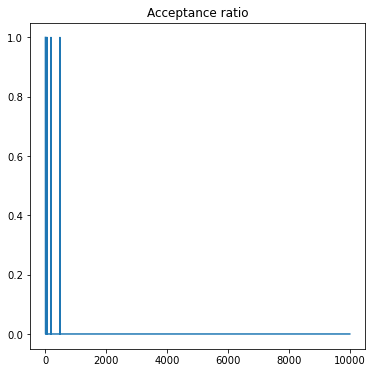

In [15]:
N_samples_x = 10000
x0 = jnp.array(np.random.randn(K))
B = 3

params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}

key, subkey = random.split(key)
t0 = time.time()
x_mean, x_r, x_samples = mcmc(subkey, proposal_x_marg, x0, N_samples_x, params_x, 1, 1)

print(f"{time.time()-t0} sec")
plt.plot(x_r); plt.title("Acceptance ratio")
print(f"x_samp = {x_samples[N_samples_x-2]}")
print(f"x_true = {x}")

#### And the non-marginalized posterior

  MCMC sample 1000 , posterior val = 3950.783
  MCMC sample 2000 , posterior val = 3948.3364
  MCMC sample 3000 , posterior val = 3948.0767
  MCMC sample 4000 , posterior val = 3950.8164
  MCMC sample 5000 , posterior val = 3951.3828
  MCMC sample 6000 , posterior val = 3947.9314
  MCMC sample 7000 , posterior val = 3947.4263
  MCMC sample 8000 , posterior val = 3942.3235
  MCMC sample 9000 , posterior val = 3951.074
3.031219959259033 sec
x_samp = [-0.42369318  0.46736884  0.7824404   0.53253865 -2.1426187   2.2475538
  0.4912119   1.0139236  -1.0549958  -1.6068614 ]
x_true = [-0.42248565  0.47037852 -0.27125207  0.5280313  -2.1492865   2.2546678
  0.49364355  1.0142431  -1.0508072  -1.6258022 ]


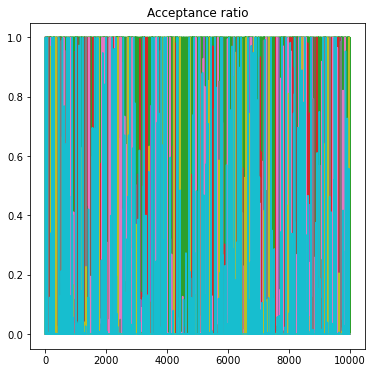

In [34]:
N_samples_x = 10000
x0 = jnp.array(np.random.randn(K))
B = 3

params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}

key, subkey = random.split(key)
t0 = time.time()
x_mean, x_r, x_samples = mcmc(subkey, proposal_x_batch, x0, N_samples_x, params_x, K, 1)

print(f"{time.time()-t0} sec")
plt.plot(x_r); plt.title("Acceptance ratio")
print(f"x_samp = {x_samples[N_samples_x-2]}")
print(f"x_true = {x}")

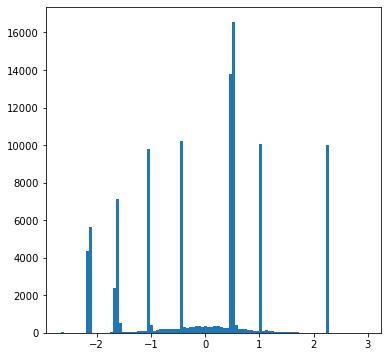

In [35]:
nbins=100
counts, bins = np.histogram(x_samples[:,:], bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

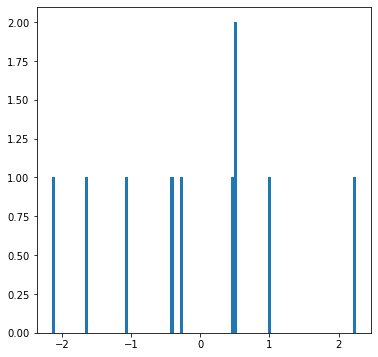

In [36]:
nbins=100
counts, bins = np.histogram(x, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

#### One $x_i$ at a time

  MCMC sample 1000, posterior val = -176852.375, a = 0.0
  MCMC sample 2000, posterior val = -176856.875, a = 0.0
  MCMC sample 3000, posterior val = -176853.015625, a = 0.0
  MCMC sample 4000, posterior val = -176852.65625, a = 0.0
  MCMC sample 5000, posterior val = -176852.859375, a = 0.0
  MCMC sample 6000, posterior val = -176853.75, a = 0.0
  MCMC sample 7000, posterior val = -176852.53125, a = 0.0
  MCMC sample 8000, posterior val = -176852.3125, a = 0.0
  MCMC sample 9000, posterior val = -176853.125, a = 0.0
  MCMC sample 10000, posterior val = -176852.296875, a = 0.0
2.8723931312561035 sec
x_samp = [ 0.10012483  0.47058392  0.3045936  -1.8647149  -2.2371473  -1.256801
  0.23737057  0.7715947  -0.5368072   0.17483206]
x_true = [-0.42248565  0.47037852 -0.27125207  0.5280313  -2.1492865   2.2546678
  0.49364355  1.0142431  -1.0508072  -1.6258022 ]


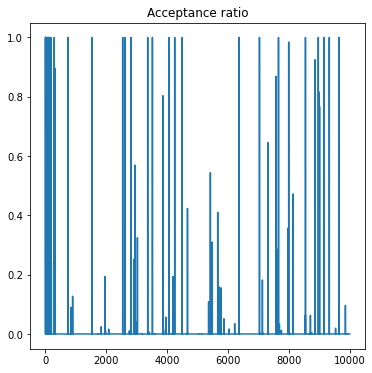

In [46]:
N_samples_x = 10001
B = 3

idx = 1
x0 = jnp.array(np.random.randn(K))

params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha, "idx": idx}

key, subkey = random.split(key)
t0 = time.time()
x_mean, x_r, x_samples = mcmc(subkey, proposal_x_idx, x0, N_samples_x, params_x, 1, 1)

print(f"{time.time()-t0} sec")
plt.plot(x_r); plt.title("Acceptance ratio")
print(f"x_samp = {x_samples[N_samples_x-2]}")
print(f"x_true = {x}")

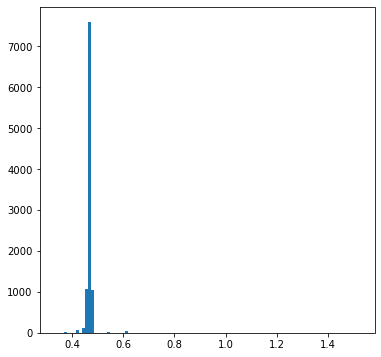

In [47]:
nbins=100
counts, bins = np.histogram(x_samples[:,idx], bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

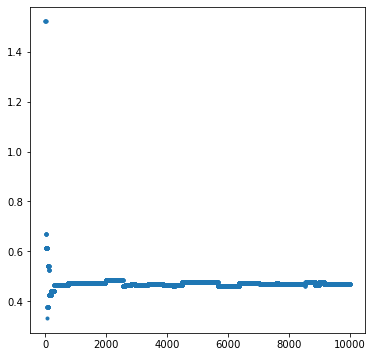

In [48]:
plt.plot(x_samples[:,idx],'.')

### Sample z

In [49]:
N_samples_z = 10000
z0 = jnp.array(np.random.randint(0, K, (N,)))
#z0 = z.at[idx].set(np.random.randint(0,K,()))

B = 2
idx = 10
#params_z = {"x" : x, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K, 'idx' : idx}
params_z = {"x" : x, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K}

key, subkey = random.split(key)

t0 = time.time()
#z_mean, z_r, z_samples = mcmc(subkey, proposal_z_idx, z0, N_samples_z, params_z, 1, 1)
z_mean, z_r, z_samples = mcmc(subkey, proposal_z_batch_correct, z0, N_samples_z, params_z, 1, 1)

z_rec = z_samples[N_samples_z-2]
print(f"{time.time()-t0} sec")
#plt.plot(z_r); plt.title("Acceptance ratio")

  MCMC sample 1000, posterior val = 4124.33837890625, a = 1.0
  MCMC sample 2000, posterior val = 4124.33837890625, a = 1.0
  MCMC sample 3000, posterior val = 4124.33837890625, a = 1.0
  MCMC sample 4000, posterior val = 4124.33837890625, a = 1.0
  MCMC sample 5000, posterior val = 4124.33837890625, a = 1.0
  MCMC sample 6000, posterior val = 4124.33837890625, a = 1.0
  MCMC sample 7000, posterior val = 4124.33837890625, a = 1.0
  MCMC sample 8000, posterior val = 4124.33837890625, a = 1.0
  MCMC sample 9000, posterior val = 4124.33837890625, a = 1.0
33.45013093948364 sec


In [50]:
jnp.sum(jnp.abs(z_rec-z))

DeviceArray(175, dtype=int32)

In [51]:
jnp.sum(jnp.abs(z0-z))

DeviceArray(3337, dtype=int32)

In [56]:
print(jnp.sum(jnp.abs(z0-z)))
print(jnp.sum(jnp.abs(z_samples[N_samples_z-2,:]-z)))

3337
175


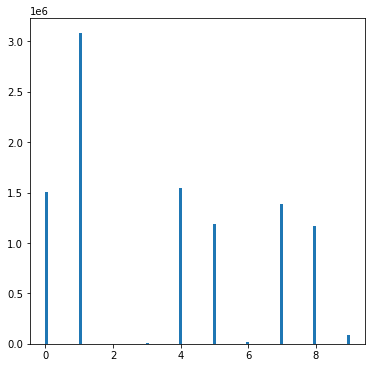

In [57]:
nbins=100
counts, bins = np.histogram(z_samples[:,:], bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

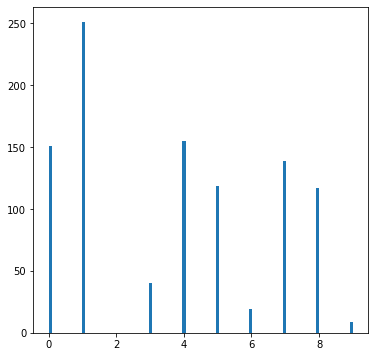

In [58]:
nbins=100
counts, bins = np.histogram(z, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

### Sample $x$ and $z$

In [59]:
N_iters = 10
N_samples_z = 1001 #300
N_samples_x = 10001
B = 3

sample_x = True
sample_z = True
search_z = False

zi = jnp.array(np.random.randint(0, K, (N,)))
xi = jnp.array(np.random.randn(K))

#xi = x
#zi = z

t0 = time.time()
for iter_i in jnp.arange(N_iters):
    print(f"Iter = {iter_i}")

    if sample_x:
        print("  Sampling x")

        params_x = {"B" : B, "z" : zi, "y" : y, "sigma" : sigma, "alpha" : alpha}

        key, subkey = random.split(key)
    
        #t0 = time.time()
        x_mean, x_r, x_samples = mcmc(subkey, proposal_x_batch, xi, N_samples_x, params_x, K, 1) 
        #x_mean, x_r, x_samples = mcmc(subkey, proposal_x_marg, xi, N_samples_x, params_x, 1, 1) 

        xi = x_samples[N_samples_x - 2]
    
    if search_z:
        print("  Searching z")
        for idx_z in tqdm(jnp.arange(N)):
            logPi_max = -jnp.inf

            for ki in jnp.arange(K):
                zi_k = zi.at[idx_z].set(ki)
                logPi_k = logPi(xi, zi_k, y, sigma, alpha)
                if logPi_k > logPi_max:
                    zi = zi_k
                    logPi_max = logPi_k
            
    if sample_z:
        print("  Sampling z")
        #for idx_z in tqdm(jnp.arange(N)):
            
        #params_z = {"x" : xi, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K, 'idx' : idx_z}
        params_z = {"x" : xi, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K}

        key, subkey = random.split(key)

        #z_mean, z_r, z_samples = mcmc(subkey, proposal_z_idx, zi, N_samples_z, params_z, 1, 1)
        #z_mean, z_r, z_samples = mcmc(subkey, proposal_z_batch, zi, N_samples_z, params_z, N, 1)
        z_mean, z_r, z_samples = mcmc(subkey, proposal_z_batch_correct, zi, N_samples_z, params_z, 1, 1)

        zi = z_samples[N_samples_z - 2]
            
print(f"{time.time()-t0} sec")
print(f"x_samp = {xi}")
print(f"x_true = {x}")

Iter = 0
  Sampling x
  MCMC sample 1000 , posterior val = -167387.02
  MCMC sample 2000 , posterior val = -167391.31
  MCMC sample 3000 , posterior val = -167390.39
  MCMC sample 4000 , posterior val = -167385.8
  MCMC sample 5000 , posterior val = -167388.52
  MCMC sample 6000 , posterior val = -167385.48
  MCMC sample 7000 , posterior val = -167387.6
  MCMC sample 8000 , posterior val = -167385.25
  MCMC sample 9000 , posterior val = -167389.8
  MCMC sample 10000 , posterior val = -167385.2
  Sampling z
  MCMC sample 1000, posterior val = -147253.1875, a = 1.0
Iter = 1
  Sampling x
  MCMC sample 1000 , posterior val = -45351.367
  MCMC sample 2000 , posterior val = -45350.49
  MCMC sample 3000 , posterior val = -45351.605
  MCMC sample 4000 , posterior val = -45349.918
  MCMC sample 5000 , posterior val = -45351.598
  MCMC sample 6000 , posterior val = -45353.06
  MCMC sample 7000 , posterior val = -45358.53
  MCMC sample 8000 , posterior val = -45349.957
  MCMC sample 9000 , poster

119
0
139
164
151
310
0
0
117
0


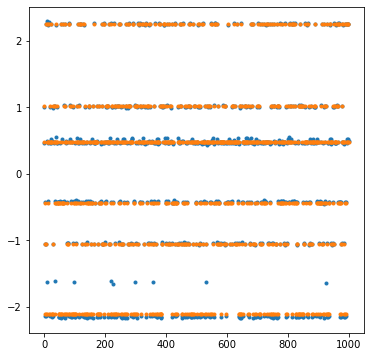

In [60]:
plt.plot(y, '.')
plt.plot(xi[zi], '.')

for k in jnp.arange(K):
    print(jnp.sum(zi==k))

In [68]:
print(logPi(x, z, y, sigma, alpha))
print(logPi(xi, zi, y, sigma, alpha))

3952.9385
3925.5513


In [69]:
z1 = z.at[0].set(1)
logPiZ0 = logPi(x, z, y, sigma, alpha)
logPiZ1 = logPi(x, z1, y, sigma, alpha)
r = jnp.exp(logPiZ1 - logPiZ0)
r

DeviceArray(7.6797477e-13, dtype=float32)

151
251
0
40
155
119
19
139
117
9


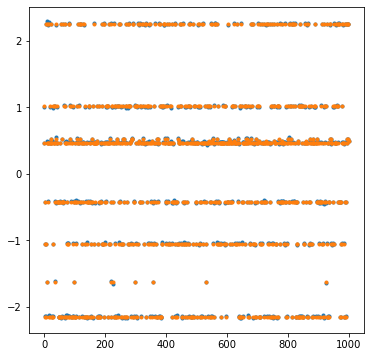

In [70]:
plt.plot(y, '.')
plt.plot(x[z], '.')

for k in jnp.arange(K):
    print(jnp.sum(z==k))

In [71]:
print(pi)
print(x)
print(xi)

[0.14755723 0.23883411 0.00259012 0.03930138 0.15887733 0.11050232
 0.01476201 0.14792879 0.12903827 0.01060837]
[-0.42248565  0.47037852 -0.27125207  0.5280313  -2.1492865   2.2546678
  0.49364355  1.0142431  -1.0508072  -1.6258022 ]
[ 2.2585936   0.16520548  1.016038   -2.109493   -0.4353912   0.47812414
  1.9868565  -0.4777193  -1.0559864  -0.50882506]


In [72]:
# Loss functions roughly equivalent with the the estimation problem to see what's going on
def loss_fun(x, z, y):
    return (x[z] - y)**2 * pi[z]

def loss_fun_vmap(x,z,y):
    n_k = calc_nk_jit(z)
    logPZalpha = jnp.sum(gammaln(n_k + alpha))
    print(f"logPZalpha = {-logPZalpha}")
    return jnp.sum(jax.vmap(loss_fun, in_axes = (None, 0, 0))(x,z,y)) + jnp.sum(x**2) - logPZalpha

In [73]:
n_k = calc_nk_jit(z)
logPZalpha =  jnp.sum(gammaln(n_k + alpha))

In [74]:
print(loss_fun_vmap(x, jnp.array(np.random.randint(0, K, (N,))), y))
print(loss_fun_vmap(xi, zi, y))
print(loss_fun_vmap(x, z, y))

logPZalpha = -3629.240966796875
-3290.352
logPZalpha = -4196.72900390625
-4180.0327
logPZalpha = -3977.590087890625
-3962.1008


### Some functions used for debugging - ignore

In [ ]:
# Quick test of a proposal function
key, subkey = random.split(key)
idx = 1
z1, rz, _, _ = proposal_z_idx(subkey, z, -1, x, y, sigma, alpha, K, idx)
print(z1[idx])
print(rz)

In [ ]:
key, subkey = random.split(key)
#z0 = random.randint(subkey, z.shape, 0, K)
z0 = jnp.ones(z.shape)
z0 = z

n_ik_z = calc_nik_jit(z0)
n_k = calc_nk_jit(z0)
Nk = jnp.sum(n_k)
Ak = jnp.sum(alpha)

In [ ]:
probs_d = []
probs_dn = []
for k in jnp.arange(K):
    probs_d.append((n_ik_z[:, k] + alpha[k])/(Nk+Ak-1))
    probs_dn.append((n_ik_z[:, k])/(Nk-1))

probs_d = jnp.array(probs_d).transpose()   
probs_dn = jnp.array(probs_dn).transpose()   

print(probs_d)
#print(jnp.sum(probs_d, axis=1))

plt.imshow(jnp.repeat(probs_d, int(N/K), axis=1)); plt.colorbar()

In [ ]:
myf = lambda x0, x1 : logPi(jnp.array([x0, x1]), z, y, sigma, alpha)
xx = jnp.linspace(-3,3,1000)    
yy = jnp.linspace(-3,3,1000)

In [ ]:
myf_x = jax.jit(lambda x : jax.vmap(myf, in_axes = (None, 0))(x, yy))
myf_xy = jax.vmap(myf_x)(xx)

In [ ]:
plt.imshow((myf_xy)); plt.colorbar()

In [ ]:
print("01", myf(x[0], x[1]))
print("00", myf(x[0], x[0]))
print("11", myf(x[1], x[1]))
print("10", myf(x[1], x[0]))

In [ ]:
myf(x[0],x[1])

In [ ]:
jnp.max(myf_xy)